In [1]:
import mlflow
from mlflow import log_metric, log_param, log_artifacts, start_run, end_run, keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob

from sklearn.model_selection import train_test_split
from sklearn import metrics

import cv2
import gc
import os

import tensorflow as tf
from tensorflow import keras
from keras import layers

import warnings
warnings.filterwarnings('ignore')



In [2]:
!nvidia-smi

Thu Jan 26 12:59:06 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.91.03    Driver Version: 460.91.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 308...  Off  | 00000000:65:00.0 Off |                  N/A |
|  0%   37C    P5    30W / 400W |     25MiB / 12053MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 308...  Off  | 00000000:B3:00.0 Off |                  N/A |
|  0%   

In [3]:
#mlflow-credentials
os.environ['AWS_ACCESS_KEY_ID'] = 'alex'
os.environ['AWS_SECRET_ACCESS_KEY'] = 'alex1234'


# Artifactory credentials
os.environ['MLFLOW_S3_ENDPOINT_URL'] = 'http://192.168.120.127:9000/'

# MLflow tracking server uri
mlflow.set_tracking_uri("http://192.168.120.127:5555/")

#__log experiment in mlflow
mlflow.set_experiment('Keras_Simple_Model')

<Experiment: artifact_location='s3://mlflow/23', creation_time=None, experiment_id='23', last_update_time=None, lifecycle_stage='active', name='Keras_Simple_Model', tags={}>

In [4]:
IMG_SIZE = 256
SPLIT = 0.1
EPOCHS = 20
BATCH_SIZE = 64

In [5]:
df = pd.read_csv("/media/HDD/shared_data/data/ki_in_mrt/Training_data_alex_T1_170123.csv")
df_abnormal = df[df["Disease"]=="abnormal"]
df_normal = df[df["Disease"]=="normal"]
print(len(df))
print(len(df_normal))
print(len(df_abnormal))

22271
11611
10660


/media/HDD/shared_data/data/ki_in_mrt/_png/0849_423622_T1_TRA_GAD/0000001.png


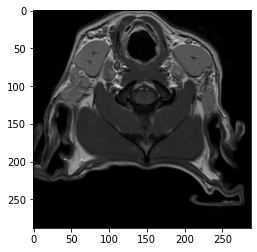

/media/HDD/shared_data/data/ki_in_mrt/_png/0161_T0418938_T1_DOR/0000043.png


/media/HDD/shared_data/data/ki_in_mrt/_png/0159_T0419386_T1_DOR/0000021.png


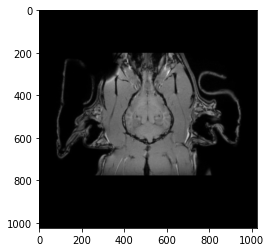

In [6]:
counter = 0
    
for index,row in df_normal.iterrows():
    counter+=1
    img = cv2.imread(row["png_file"])
    print(row["png_file"])
    plt.imshow(img)
    plt.show()
    if counter==3:
        break

In [12]:
X=[]
Y=[]

for index,row in df_normal.iterrows():
    img = cv2.imread(row["png_file"],0)

    X.append(cv2.resize(img,(IMG_SIZE,IMG_SIZE)))
    Y.append(0)

for index,row in df_abnormal.iterrows():
    img = cv2.imread(row["png_file"],0)
    X.append(cv2.resize(img,(IMG_SIZE,IMG_SIZE)))
    Y.append(1)

X = np.asarray(X)
one_hot_encoded_Y = pd.get_dummies(Y).values



In [ ]:
# X=[]
# Y=[]

# for index,row in df_normal.iterrows():
#     img = cv2.imread(row["png_file"],0)
#     img = cv2.normalize(img, None, alpha = 0, beta = np.max(img), norm_type = cv2.NORM_MINMAX)    
#     img = img / 255.
#     X.append(cv2.resize(img,(IMG_SIZE,IMG_SIZE)))
#     Y.append(0)

# for index,row in df_abnormal.iterrows():
#     img = cv2.imread(row["png_file"],0)
#     img= cv2.normalize(img, None, alpha = 0, beta = np.max(img), norm_type = cv2.NORM_MINMAX)    
#     img = img / 255.
#     X.append(cv2.resize(img,(IMG_SIZE,IMG_SIZE)))
#     Y.append(1)

# X = np.asarray(X)
# one_hot_encoded_Y = pd.get_dummies(Y).values



In [16]:
X_t, X_test, Y_t, Y_test = train_test_split(
X, one_hot_encoded_Y, test_size = SPLIT, stratify=one_hot_encoded_Y,random_state=333)
print("train+val: ", len(X_t), "| test: ", len(X_test))

X_train, X_val, Y_train, Y_val = train_test_split(
X_t, Y_t, test_size = SPLIT, random_state = 199)
print("train: ",len(X_train),"| validation: ",  len(X_val))

train+val:  20043 | test:  2228
train:  18038 | validation:  2005


In [17]:
model = keras.models.Sequential([
	layers.Conv2D(filters=32,
				kernel_size=(5, 5),
				activation='relu',
				input_shape=(IMG_SIZE,
							IMG_SIZE,
							1),
				padding='same'),
	layers.MaxPooling2D(2, 2),

	layers.Conv2D(filters=64,
				kernel_size=(3, 3),
				activation='relu',
				padding='same'),
	layers.MaxPooling2D(2, 2),

	layers.Conv2D(filters=128,
				kernel_size=(3, 3),
				activation='relu',
				padding='same'),
	layers.MaxPooling2D(2, 2),

	layers.Flatten(),
	layers.Dense(256, activation='relu'),
	layers.BatchNormalization(),
	layers.Dense(128, activation='relu'),
	layers.Dropout(0.3),
	layers.BatchNormalization(),
	layers.Dense(2, activation='softmax')
])




2023-01-26 13:10:15.110430: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-26 13:10:15.778842: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10073 MB memory:  -> device: 0, name: GeForce RTX 3080 Ti, pci bus id: 0000:65:00.0, compute capability: 8.6
2023-01-26 13:10:15.779663: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 10092 MB memory:  -> device: 1, name: GeForce RTX 3080 Ti, pci bus id: 0000:b3:00.0, compute capability: 8.6


In [18]:
# from keras import layers
# from keras.models import *
# from keras.layers import *
# def SimpleModelOri2(input_size=(IMG_SIZE,IMG_SIZE, 1)):
#     Eingabe = Input(input_size)

#     Conv1 = Conv2D(32, (5,5), padding="same")(Eingabe)
#     Batch1 = BatchNormalization(axis=-1)(Conv1)
#     Act1 = Activation("relu")(Batch1)
    
#     Down1 =  Conv2D(64, (3,3), strides=(2,2), padding="same")(Act1)
#     DownBatch1 = BatchNormalization(axis=-1)(Down1)
#     DownAct1 = Activation("relu")(DownBatch1)

#     Conv2 = Conv2D(64, (3,3), padding="same")(DownAct1)
#     Batch2 = BatchNormalization(axis=-1)(Conv2)
#     Act2 = Activation("relu")(Batch2)

#     Down2 = Conv2D(128, (3,3), strides=(2,2), padding="same")(Act2)
#     DownBatch2 = BatchNormalization(axis=-1)(Down2)
#     DownAct2 = Activation("relu")(DownBatch2)

#     Conv3 = Conv2D(128, (3,3), padding="same")(DownAct2)
#     Batch3 = BatchNormalization(axis=-1)(Conv3)
#     Act3 = Activation("relu")(Batch3)
    
#     Down3 = Conv2D(256, (3,3), strides=(2,2), padding="same")(Act3)
#     DownBatch3 = BatchNormalization(axis=-1)(Down3)
#     DownAct3 = Activation("relu")(DownBatch3)
    
#     OutFlat = Flatten()(DownAct3)

#     OutDense1 = Dense(256)(OutFlat)
#     OutBatch1 = BatchNormalization(axis=-1)(OutDense1)
#     OutAct1 = Activation("relu")(OutBatch1)

#     OutDense2 = Dense(128)(OutAct1)
#     OutBatch2 = BatchNormalization(axis=-1)(OutDense2)
#     OutAct2 = Activation("relu")(OutBatch2)

#     OutDrop = Dropout(0.3)(OutDense2)

#     OutDense3 = Dense(2, activation='softmax')(OutDrop)

#     model = Model(inputs = Eingabe, outputs = OutDense3)

#     # Original LR = 0.001 -> seems abit too jumpy without augmentation
#     opt = tf.keras.optimizers.Adam(learning_rate=0.00075)
#     #Metrics = keras.metrics.CategoricalAccuracy()
#     Losses = tf.keras.losses.CategoricalCrossentropy()

#     model.compile(optimizer = opt, loss = Losses, metrics = ['accuracy'])

#     return model

# model = SimpleModelOri2()

In [19]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
# model.summary()

In [20]:

# opt = tf.keras.optimizers.Adam(learning_rate=0.00075)
# model.compile(
#     optimizer=opt,
#     loss='categorical_crossentropy',
#     metrics=['accuracy']
# )

In [21]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = {}):
        if logs.get('val_accuracy') > 0.98:
            print('\n Validation accuracy has reached upto 98%\
            so, stopping further training.')
            self.model.stop_training = True

es = EarlyStopping(patience = 3,
                monitor = 'val_accuracy',
                restore_best_weights = True)

lr = ReduceLROnPlateau(monitor = 'val_loss',
                    patience = 2,
                    factor = 0.5,
                    verbose = 1)


In [22]:
mlflow.end_run()
mlflow.start_run()
mlflow.keras.autolog()

In [23]:

history = model.fit(X_train, Y_train,
					validation_data = (X_val, Y_val),
					batch_size = BATCH_SIZE,
					epochs = EPOCHS,
					verbose = 1,
					callbacks = [es, lr, myCallback()])
# mlflow.keras.log_model(model, "keras_model_mlflow")
mlflow.end_run()

2023-01-26 13:10:18.874327: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 4728553472 exceeds 10% of free system memory.
2023-01-26 13:10:21.646900: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 4728553472 exceeds 10% of free system memory.


Epoch 1/20


2023-01-26 13:10:25.028863: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8101
2023-01-26 13:10:26.458092: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


282/282 [==============================] - 16s 45ms/step - loss: 0.6381 - accuracy: 0.6825 - val_loss: 1.1737 - val_accuracy: 0.5746 - lr: 0.0010
Epoch 2/20
282/282 [==============================] - 11s 41ms/step - loss: 0.3373 - accuracy: 0.8549 - val_loss: 0.5185 - val_accuracy: 0.7631 - lr: 0.0010
Epoch 3/20
282/282 [==============================] - 11s 40ms/step - loss: 0.1708 - accuracy: 0.9363 - val_loss: 0.5857 - val_accuracy: 0.8015 - lr: 0.0010
Epoch 4/20
282/282 [==============================] - 11s 41ms/step - loss: 0.1034 - accuracy: 0.9655 - val_loss: 0.3465 - val_accuracy: 0.8663 - lr: 0.0010
Epoch 5/20
282/282 [==============================] - 11s 40ms/step - loss: 0.0634 - accuracy: 0.9802 - val_loss: 0.4662 - val_accuracy: 0.8648 - lr: 0.0010
Epoch 6/20
281/282 [============================>.] - ETA: 0s - loss: 0.0530 - accuracy: 0.9835
Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
282/282 [==============================] - 11s 41m

2023-01-26 13:12:34.424957: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /tmp/tmpupihctvo/model/data/model/assets


2023/01/26 13:12:48 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpupihctvo/model, flavor: tensorflow), fall back to return ['tensorflow==2.7.0']. Set logging level to DEBUG to see the full traceback.


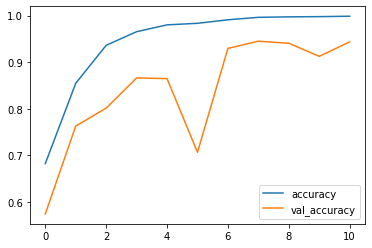

In [24]:
history_df = pd.DataFrame(history.history)
history_df.loc[:,['loss','val_loss']].plot()
history_df.loc[:,['accuracy','val_accuracy']].plot()
plt.show()


In [25]:
Y_pred = model.predict(X_test)

Y_test = np.argmax(Y_test, axis=1)
Y_pred = np.argmax(Y_pred, axis=1)


In [26]:
metrics.confusion_matrix(Y_test, Y_pred)


array([[1100,   62],
       [  72,  994]])

In [27]:
print(metrics.classification_report(Y_test, Y_pred,
									target_names=["normal","abnormal"]))


              precision    recall  f1-score   support

      normal       0.94      0.95      0.94      1162
    abnormal       0.94      0.93      0.94      1066

    accuracy                           0.94      2228
   macro avg       0.94      0.94      0.94      2228
weighted avg       0.94      0.94      0.94      2228



In [28]:
# from numba import cuda 
# device = cuda.select_device(0)
# device.reset()
# device = cuda.select_device(1)
# device.reset()

In [29]:
for i,j in zip(Y_test,Y_pred):
    print(f"actual {i} <--> {j} predicted")

actual 1 <--> 1 predicted
actual 1 <--> 1 predicted
actual 1 <--> 1 predicted
actual 0 <--> 0 predicted
actual 1 <--> 1 predicted
actual 1 <--> 1 predicted
actual 1 <--> 1 predicted
actual 0 <--> 0 predicted
actual 0 <--> 0 predicted
actual 1 <--> 1 predicted
actual 1 <--> 1 predicted
actual 1 <--> 1 predicted
actual 0 <--> 1 predicted
actual 1 <--> 1 predicted
actual 1 <--> 1 predicted
actual 0 <--> 0 predicted
actual 0 <--> 0 predicted
actual 0 <--> 0 predicted
actual 1 <--> 1 predicted
actual 1 <--> 1 predicted
actual 0 <--> 0 predicted
actual 0 <--> 0 predicted
actual 0 <--> 0 predicted
actual 1 <--> 1 predicted
actual 1 <--> 1 predicted
actual 0 <--> 0 predicted
actual 1 <--> 1 predicted
actual 1 <--> 1 predicted
actual 0 <--> 0 predicted
actual 0 <--> 0 predicted
actual 1 <--> 1 predicted
actual 0 <--> 0 predicted
actual 1 <--> 1 predicted
actual 1 <--> 1 predicted
actual 0 <--> 0 predicted
actual 1 <--> 1 predicted
actual 0 <--> 0 predicted
actual 0 <--> 0 predicted
actual 1 <--

In [30]:
a=5

In [31]:
X

array([[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

       [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 